In [1]:
!pip install ninja

In [2]:
import torch

torch.manual_seed(42)
N, K, M = 2, 4096, 4096
bits = 4

weight_fp16 = torch.randn(M, K) # [Out, In]

# scale과 zeropoint 임의로 설정
"""
    qweight_int: [Output, Input] 형태의 INT4 가중치
    scales: [Output, 1(Group)] 형태의 FP16 스케일
    zeros: [Output, 1(Group)] 형태의 Zero-point
"""

w_min = weight_fp16.min(dim = 1, keepdim=True)[0]
w_max = weight_fp16.max(dim = 1, keepdim=True)[0]

scales = (w_max - w_min) / 15

zero_point = torch.round(-1 * w_min / scales)
zero_point = torch.clamp(zero_point, 0, 15)

qweight_int4 = torch.clamp(torch.round(weight_fp16 / scales + zero_point), 0, 15).to(torch.int32)

print(f"원본 크기 : {weight_fp16.shape}")
print(f"int4 가중치 크기 : {qweight_int4.shape}")


원본 크기 : torch.Size([4096, 4096])
int4 가중치 크기 : torch.Size([4096, 4096])


In [3]:
def preprocess_optq_to_bcq(w_int4, scale, zero, bits = 4):

    """
    입력:
      w_int4: [Out, In] (0~15 값)
      scale:  [Out, 1]
      zero:   [Out, 1]
    출력:
      alphas: [Out, 1, Bits] (비트별 스케일)
      bias:   [Out, 1]       (보정된 Bias)
    """

    alphas = []
    for i in range(bits):
        alpha_idx = scale * (2 ** (i - 1))
        alphas.append(alpha_idx)

    alphas = torch.stack(alphas, dim = -1) # [Out, 1, bits]

    bias_orig = -1.0 * scales * zero

    bias_shift = 0
    for i in range(bits):
        bias_shift += scale * (2 ** (i - 1))

    bias = bias_orig + bias_shift

    return alphas, bias

# 패킹 함수 구현
def pack_int4_weights(qweight):
    """
    입력: [M, K] (int32, 값 범위 0~15)
    출력: [M, K // 8] (int32, 패킹된 값)
    """
    M, K = qweight.shape
    pack_num = 8 # 32bit / 4bit = 8개

    assert K % pack_num == 0, "K(Input Dimension)가 8의 배수여야 패킹이 가능합니다."

    # 1. [M, K/8, 8] 형태로 변환 (마지막 차원에 8개씩 묶음)
    w_reshaped = qweight.reshape(M, K // pack_num, pack_num)

    # 2. 비트 시프트 연산을 위한 시프트 값 생성 (0, 4, 8, ..., 28)
    # Little-endian 방식: 첫 번째 가중치가 하위 비트(LSB)에 위치
    shifts = torch.arange(0, 32, 4, device=qweight.device).reshape(1, 1, -1)

    # 3. 시프트 적용 후 합산 (Bitwise OR와 동일한 효과)
    packed_tensor = (w_reshaped << shifts).sum(dim=-1)

    return packed_tensor.to(torch.int32)

# 언패킹 함수 (검증용)
def unpack_int4_weights(packed_weight):
    """
    입력: [M, K // 8]
    출력: [M, K]
    """
    M, K_packed = packed_weight.shape
    pack_num = 8

    # 1. 차원 확장 [M, K_packed, 1]
    packed_weight = packed_weight.unsqueeze(-1)

    # 2. 시프트 값
    shifts = torch.arange(0, 32, 4, device=packed_weight.device).reshape(1, 1, -1)

    # 3. 시프트 후 마스킹 (0xF = 1111(2))
    unpacked = (packed_weight >> shifts) & 0xF

    # 4. 원래 모양 [M, K]로 펼치기
    return unpacked.reshape(M, -1)

In [4]:
# 패킹 실행
B_packed = pack_int4_weights(qweight_int4)

print(f"패킹된 가중치 형태 (Packed): {B_packed.shape}") # [64, 4] -> 32가 4로 줄어듦 (1/8)


bcq_alphas, bcq_bias = preprocess_optq_to_bcq(qweight_int4, scales, zero_point, bits=bits)


qweight_unpacked = unpack_int4_weights(B_packed)

# 패킹 과정에서 데이터 손실이 없는지 확인
pack_error = (qweight_int4 - qweight_unpacked).abs().sum()
print(f"패킹/언패킹 무결성 검사 오차: {pack_error.item()}")

# BCQ 복원 (언패킹된 값 사용)
w_recon = torch.zeros_like(weight_fp16)
for i in range(bits):
    # 언패킹된 qweight_unpacked 사용
    bit_val = (qweight_unpacked.int() // (2**i)) % 2
    bcq_bit = bit_val * 2 - 1
    w_recon += bcq_bit * bcq_alphas[..., i]

w_recon += bcq_bias

target_recon = scales * (qweight_int4 - zero_point)
error = (target_recon - w_recon).abs().max()
print(f"BCQ 복원 오차: {error.item():.8f}")


# GPU Kernel Input:
# 1. B_packed (int32, [64, 4])
# 2. bcq_alphas (fp32, [64, 1, 4]) -> 보통 Flatten해서 보냄
# 3. bcq_bias (fp32, [64, 1])

패킹된 가중치 형태 (Packed): torch.Size([4096, 512])
패킹/언패킹 무결성 검사 오차: 0
BCQ 복원 오차: 0.00000095


In [5]:
# 테스트 데이터
device = 'cuda'
A = torch.randn(N, K).to(device)

# B는 가중치 [K/8, M]
B_quant = B_packed.T.contiguous().to(dtype=torch.int32).to(device)

alpha = bcq_alphas.squeeze(1).T.contiguous().to(device)

In [6]:
from torch.utils.cpp_extension import load_inline

cuda_source = """
/*
    Input A: [N, K] (FP32)
    Weight B: [K/8, M] (Packed INT4 -> INT32)
    32비트 정수 하나에 8개의 4비트 가중치가 K 차원을 따라 패킹됨
    Output C: [N, M] (FP32)
    Alpha: [4, M]
 */

#include <cuda_runtime.h>

__global__ void lut_gemm(
    const float* A,
    const int* B,       // [K/8, M] 크기의 패킹된 가중치
    float* C,
    const float* alpha,
    int N, int K, int M,
    unsigned long long* debug_lut_cycles,
    unsigned long long* debug_compute_cycles
) {

    int row = blockIdx.y; // N ( batch 전체)
    int col = blockIdx.x * blockDim.x + threadIdx.x; // M
    int tid = threadIdx.x;


    // mu = 4 라고 가정
    __shared__ float lut[16];// (이런 식으로 하면 노는 스레드가 발생할 수 있으나 어차피 간략하게 테스트 용이니 나중에 생각 )

    float acc = 0.0f; // ALU

    // 로컬 카운터
    unsigned long long local_lut_time = 0;
    unsigned long long local_compute_time = 0;

    // 논문에서는 K_TILE_SIZE = 32 이지만 현재 코드에서는 K 전체를 4개 씩 타일링 해서 처리
    for (int k = 0; k < K; k+=4){

        // 측정
        long long t0 = clock64();

        if (tid < 16){
            /*
            Optimization:
                데이터를 하나씩 가져오지 말고 int4로 여러개 같고와서 공유메모리에 저장하기(공유 메모리가 남는다면)
                reinterpret_cast 사용 가능
            */
            float a0 = (k + 0 < K) ? A[row * K + (k + 0)] : 0.0f;
            float a1 = (k + 1 < K) ? A[row * K + (k + 1)] : 0.0f;
            float a2 = (k + 2 < K) ? A[row * K + (k + 2)] : 0.0f;
            float a3 = (k + 3 < K) ? A[row * K + (k + 3)] : 0.0f;

            float pattern_sum =     + (2 * ((tid >> 0) & 1) - 1) * a0
                                    + (2 * ((tid >> 1) & 1) - 1) * a1
                                    + (2 * ((tid >> 2) & 1) - 1) * a2
                                    + (2 * ((tid >> 3) & 1) - 1) * a3;

            lut[tid] = pattern_sum;

        }

        __syncthreads();

        // 분기점
        long long t1 = clock64();

        if (col < M) {

            // B는 [K/8, M] 크기이므로, 현재 k가 속한 패킹된 인덱스를 찾음
            // 예: k=0~7은 index 0, k=8~15는 index 1 ...
            int packed_idx = (k / 8) * M + col;
            int packed_val = B[packed_idx];

            // 비트 추출 로직
            // 4개씩 뽑아쓰기
            int shift_amount = (k % 8) * 4;

            int current_amount = packed_val >> shift_amount;

            // 4개의 가중치(b0~b3) 추출
            int b0 = (current_amount >> 0)  & 0xF;
            int b1 = (current_amount >> 4)  & 0xF;
            int b2 = (current_amount >> 8)  & 0xF;
            int b3 = (current_amount >> 12) & 0xF;

            for (int b=0; b < 4; ++b) {
                // 각 가중치 b번째 비트
                int bit0 = (b0 >> b) & 1;
                int bit1 = (b1 >> b) & 1;
                int bit2 = (b2 >> b) & 1;
                int bit3 = (b3 >> b) & 1;

                int pattern_idx = (bit3 << 3) | (bit2 << 2) | (bit1 << 1) | bit0;

                /*
                Optimization:
                    alpha를 사용 할 때마다 글로벌 메모리에 접근하게 하지 말고
                    루프 이전에 알파를 레지스터로 이동
                */
                acc += lut[pattern_idx] * alpha[b * M + col];
            }
        }
        __syncthreads();

        // 종료
        long long t2 = clock64();

        // tid == 0 일 때, 대표로 측정
        // 워프 내 실행 흐름은 같으니
        if (tid == 0) {
            local_lut_time += t1 - t0;
            local_compute_time += t2 - t1;
        }
    }

    if (col < M && row < N) {
        C[row * M + col] = acc;
    }

    // 결과 합
    if (tid == 0) {
        atomicAdd(debug_lut_cycles, local_lut_time);
        atomicAdd(debug_compute_cycles, local_compute_time);
    }
}
"""


cpp_source = """torch::Tensor run_lut_profile(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                                        torch::Tensor debug_lut, torch::Tensor debug_compute);
                                        """

# 래퍼 함수
cuda_wrapper = """
torch::Tensor run_lut_profile(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                          torch::Tensor debug_lut, torch::Tensor debug_compute)  {
    int N = A.size(0);
    int K = A.size(1);
    int M = B.size(1); // Weight [K/8, M]

    auto C = torch::zeros({N, M}, A.options());

    // Block: 128 threads handling M dimension
    dim3 block(128, 1);

    dim3 grid((M + 127) / 128, N);

    lut_gemm<<<grid, block>>>(
        A.data_ptr<float>(),
        B.data_ptr<int>(),
        C.data_ptr<float>(),
        Alpha.data_ptr<float>(),
        N, K, M,
        (unsigned long long*)debug_lut.data_ptr(),
        (unsigned long long*)debug_compute.data_ptr()
    );
    return C;
}
"""
full_cuda_source = cuda_source + cuda_wrapper

lut_profile = load_inline(
    name='lut_gemm',
    cpp_sources=cpp_source,
    cuda_sources=full_cuda_source,
    functions=['run_lut_profile'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"]
)

In [7]:
from torch.utils.cpp_extension import load_inline

cuda_source = """
#include <cuda_runtime.h>

__global__ void baseline_dequant_gemm_profiled(
    const float* A,
    const int* B,
    float* C,
    const float* alpha,
    int N, int K, int M,
    unsigned long long* debug_compute_cycles
) {
    int row = blockIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int tid = threadIdx.x;

    float acc = 0.0f;

    // 로컬 카운터
    unsigned long long local_cycles = 0;

    for (int k = 0; k < K; k+=4){

        // 측정
        // lut 생성 과정 없음
        long long t0 = clock64();

        if (col < M) {

            // 2. Input 로드
            float a0 = (k + 0 < K) ? A[row * K + (k + 0)] : 0.0f;
            float a1 = (k + 1 < K) ? A[row * K + (k + 1)] : 0.0f;
            float a2 = (k + 2 < K) ? A[row * K + (k + 2)] : 0.0f;
            float a3 = (k + 3 < K) ? A[row * K + (k + 3)] : 0.0f;

            // B는 [K/8, M] 크기이므로, 현재 k가 속한 패킹된 인덱스를 찾음
            int packed_idx = (k / 8) * M + col;
            int packed_val = B[packed_idx];

            // 비트 추출 로직
            // 4개씩 뽑아쓰기
            int shift_amount = (k % 8) * 4;

            int current_amount = packed_val >> shift_amount;

            // 여기서 스케일링 팩터는 원본 스케일 값이어야함
            // 여기서는 Channel-wise Quantization을 가정
            float scale = alpha[col];

            // 비트 연산으로 쪼개고 -> 실수로 변환 -> 스케일 곱하기 -> 입력과 곱하기

            // Weight 0
            int b0_int = (current_amount >> 0) & 0xF;
            float b0_fp = (float)b0_int * scale; // Dequant overhead
            acc += b0_fp * a0;

            // Weight 1
            int b1_int = (current_amount >> 4) & 0xF;
            float b1_fp = (float)b1_int * scale;
            acc += b1_fp * a1;

            // Weight 2
            int b2_int = (current_amount >> 8) & 0xF;
            float b2_fp = (float)b2_int * scale;
            acc += b2_fp * a2;

            // Weight 3
            int b3_int = (current_amount >> 12) & 0xF;
            float b3_fp = (float)b3_int * scale;
            acc += b3_fp * a3;
        }

        // [타이머 종료]
        long long t1 = clock64();

        if (tid == 0) {
            local_cycles += t1 - t0;
        }
    }

    if (col < M && row < N) {
        C[row * M + col] = acc;
    }

    if (tid == 0) {
        atomicAdd(debug_compute_cycles, local_cycles);
    }
}
"""


cpp_source = """torch::Tensor run_baseline(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                                        torch::Tensor debug_compute);
                                        """

# 래퍼 함수
cuda_wrapper = """
torch::Tensor run_baseline(torch::Tensor A, torch::Tensor B, torch::Tensor Alpha,
                          torch::Tensor debug_compute)  {
    int N = A.size(0);
    int K = A.size(1);
    int M = B.size(1); // Weight [K, M]

    auto C = torch::zeros({N, M}, A.options());

    // Block: 128 threads handling M dimension
    dim3 block(128, 1);

    dim3 grid((M + 127) / 128, N);

    baseline_dequant_gemm_profiled<<<grid, block>>>(
        A.data_ptr<float>(),
        B.data_ptr<int>(),
        C.data_ptr<float>(),
        Alpha.data_ptr<float>(),
        N, K, M,
        (unsigned long long*)debug_compute.data_ptr()
    );
    return C;
}
"""
full_cuda_source = cuda_source + cuda_wrapper

baseline_profile = load_inline(
    name='baseline_dequant_gemm_profiled',
    cpp_sources=cpp_source,
    cuda_sources=full_cuda_source,
    functions=['run_baseline'],
    with_cuda=True,
    extra_cuda_cflags=["-O2"]
)

In [13]:
import matplotlib.pyplot as plt

batch_sizes = [1, 16, 32, 64, 128, 256, 512, 1024]
lut_ratios = []
lut_times = []
compute_times = []
base_cimpute_times = []

print(f"{'Batch':<10} | {'LUT Cycles':<15} | {'Comp Cycles':<15} | {'Base Comp Cycles':<15} | {'LUT Ratio (%)':<15}")
print("-" * 65)

for N in batch_sizes:
    A = torch.randn(N, K).to(device)

    # 디버그 카운터 초기화
    debug_lut = torch.zeros(1, dtype=torch.int64, device=device)
    debug_compute = torch.zeros(1, dtype=torch.int64, device=device)
    debug_compute_baseline = torch.zeros(1, dtype=torch.int64, device=device)

    # 측정
    debug_lut.zero_()
    debug_compute.zero_()
    debug_compute_baseline.zero_()

    lut_profile.run_lut_profile(A, B_quant, alpha, debug_lut, debug_compute)
    baseline_profile.run_baseline(A, B_quant, alpha, debug_compute_baseline)
    torch.cuda.synchronize()

    l_time = debug_lut.item()
    c_time = debug_compute.item()
    base_c_time = debug_compute_baseline.item()

    total = l_time + c_time
    ratio = (l_time / total) * 100 if total > 0 else 0

    lut_ratios.append(ratio)
    lut_times.append(l_time)
    compute_times.append(c_time)
    base_cimpute_times.append(base_c_time)

    print(f"{N:<10} | {l_time:<15} | {c_time:<15} | {base_c_time:<15} | {ratio:.2f}%")


Batch      | LUT Cycles      | Comp Cycles     | Base Comp Cycles | LUT Ratio (%)  
-----------------------------------------------------------------
1          | 7190270         | 11336583        | 8311173         | 38.81%
16         | 156036294       | 277347346       | 184372305       | 36.00%
32         | 329740155       | 585258480       | 390168596       | 36.04%
64         | 676172707       | 1196481584      | 798563073       | 36.11%
128        | 1368451482      | 2417578355      | 1615298502      | 36.14%
256        | 2754358732      | 4861883662      | 3250008175      | 36.16%
512        | 5995434431      | 10216667517     | 7233754001      | 36.98%
1024       | 12186504055     | 20688329480     | 13917257185     | 37.07%


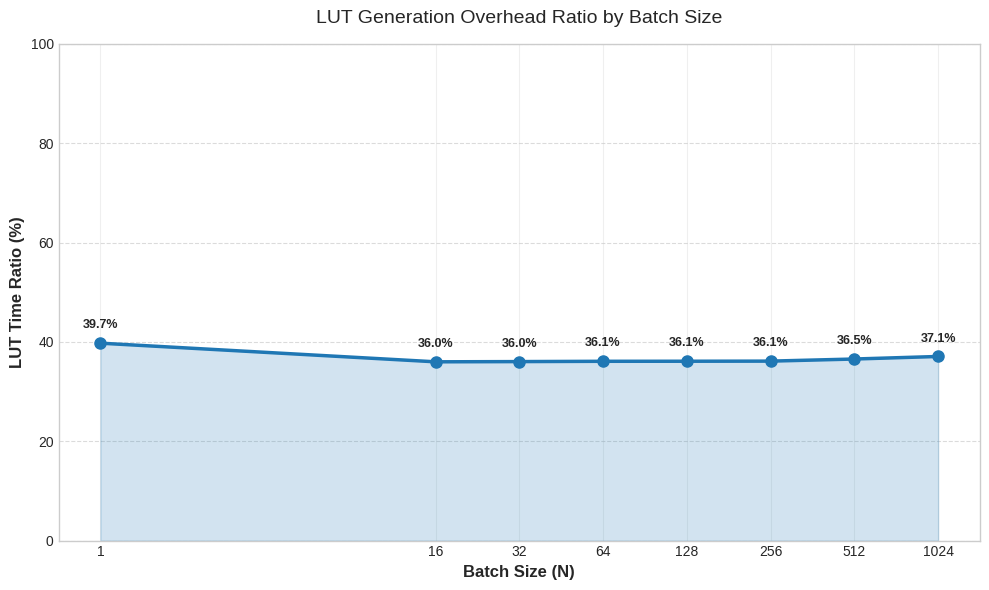

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # 축 서식용

# 1. 깔끔한 스타일 설정 (없으면 생략 가능하지만 추천)
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot') # seaborn 스타일이 없을 경우 대체

plt.figure(figsize=(10, 6))

# 2. 메인 그래프 그리기 (선 디자인 개선)
plt.plot(batch_sizes, lut_ratios,
         marker='o', markersize=8, linewidth=2.5,
         linestyle='-', color='#1f77b4', label='LUT Overhead (%)')

# 3. 아래 영역 채우기 (시각적 강조)
plt.fill_between(batch_sizes, lut_ratios, alpha=0.2, color='#1f77b4')

# 4. 축 설정 (로그 스케일 + 난잡한 세로줄 제거 핵심!)
plt.xscale('log')
plt.xticks(batch_sizes, labels=batch_sizes, fontsize=10) # X축 라벨 직접 지정
plt.minorticks_off() # [핵심] 로그 스케일의 자잘한 보조 눈금 제거

# Y축 범위 및 라벨 설정
plt.ylim(0, 100) # 0~100%로 고정
plt.ylabel('LUT Time Ratio (%)', fontsize=12, fontweight='bold')
plt.xlabel('Batch Size (N)', fontsize=12, fontweight='bold')

# 5. 그리드 커스텀 (가로줄은 점선으로, 세로줄은 주요 지점만)
plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.7)
plt.grid(True, which='major', axis='x', linestyle='-', alpha=0.3) # 세로줄은 연하게

# 6. 제목 및 값 표시
plt.title('LUT Generation Overhead Ratio by Batch Size', fontsize=14, pad=15)

# 각 포인트에 실제 % 값 텍스트로 달기
for x, y in zip(batch_sizes, lut_ratios):
    plt.text(x, y + 3, f"{y:.1f}%", ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

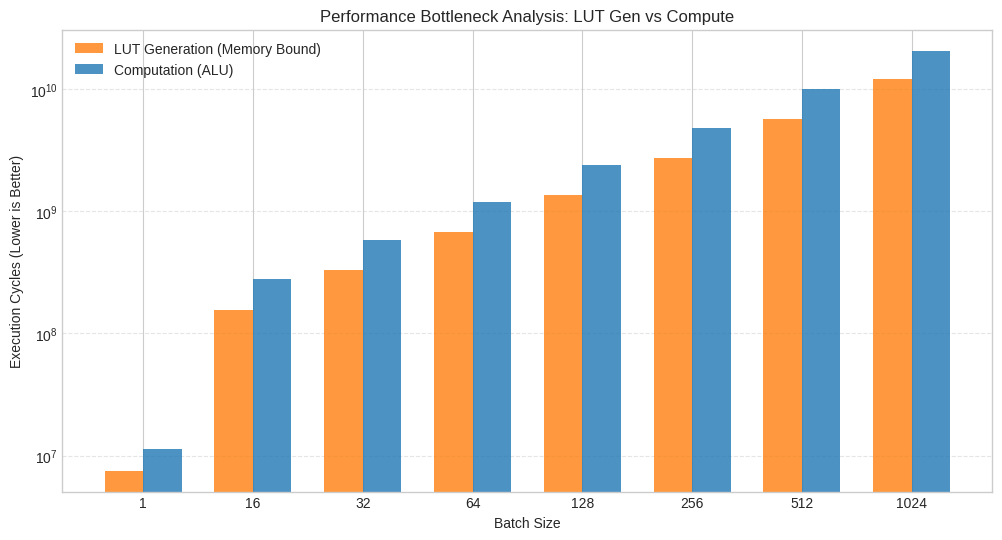

In [11]:
import numpy as np

# 데이터 준비 (ms 단위 변환 가정, 예시 데이터 사용 시 수정 필요)
# lut_times, compute_times 리스트가 있다고 가정
x_indices = np.arange(len(batch_sizes))
width = 0.35

plt.figure(figsize=(12, 6))

# 막대 그래프 그리기
plt.bar(x_indices - width/2, lut_times, width, label='LUT Generation (Memory Bound)', color='#ff7f0e', alpha=0.8)
plt.bar(x_indices + width/2, compute_times, width, label='Computation (ALU)', color='#1f77b4', alpha=0.8)

# X축 설정
plt.xticks(x_indices, batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Execution Cycles (Lower is Better)')
plt.yscale('log') # 사이클 차이가 크면 로그 스케일 추천 (아니면 제거)
plt.title('Performance Bottleneck Analysis: LUT Gen vs Compute')

plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()